# Clasificación de Melanoma con EfficientNetV2-S

## Dataset: DermMel (Balanceado)

Este notebook implementa un clasificador binario de melanoma utilizando Transfer Learning con EfficientNetV2-S preentrenado en ImageNet.

**Características del dataset:**
- **Balanceado**: Igual cantidad de melanomas y no melanomas
- **División**: train_sep / valid / test
- **Estructura**: Ya organizado en carpetas por clase

## 1. Configuración Inicial y Librerías

In [226]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("drscarlat/melanoma")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/melanoma


In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from glob import glob

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline
pd.set_option('display.max_columns', None)

In [228]:
# Ruta al dataset DermMel
dataset_path = '/kaggle/input/melanoma/DermMel'

# Verificar estructura
for split in ['train_sep', 'valid', 'test']:
    split_path = os.path.join(dataset_path, split)
    melanoma_count = len(os.listdir(os.path.join(split_path, 'Melanoma')))
    not_melanoma_count = len(os.listdir(os.path.join(split_path, 'NotMelanoma')))
    print(f"\n{split.upper()}:")
    print(f"  Melanoma: {melanoma_count}")
    print(f"  NotMelanoma: {not_melanoma_count}")
    print(f"  Total: {melanoma_count + not_melanoma_count}")


TRAIN_SEP:
  Melanoma: 5341
  NotMelanoma: 5341
  Total: 10682

VALID:
  Melanoma: 1781
  NotMelanoma: 1781
  Total: 3562

TEST:
  Melanoma: 1781
  NotMelanoma: 1780
  Total: 3561


## 2. Visualización de Ejemplos del Dataset

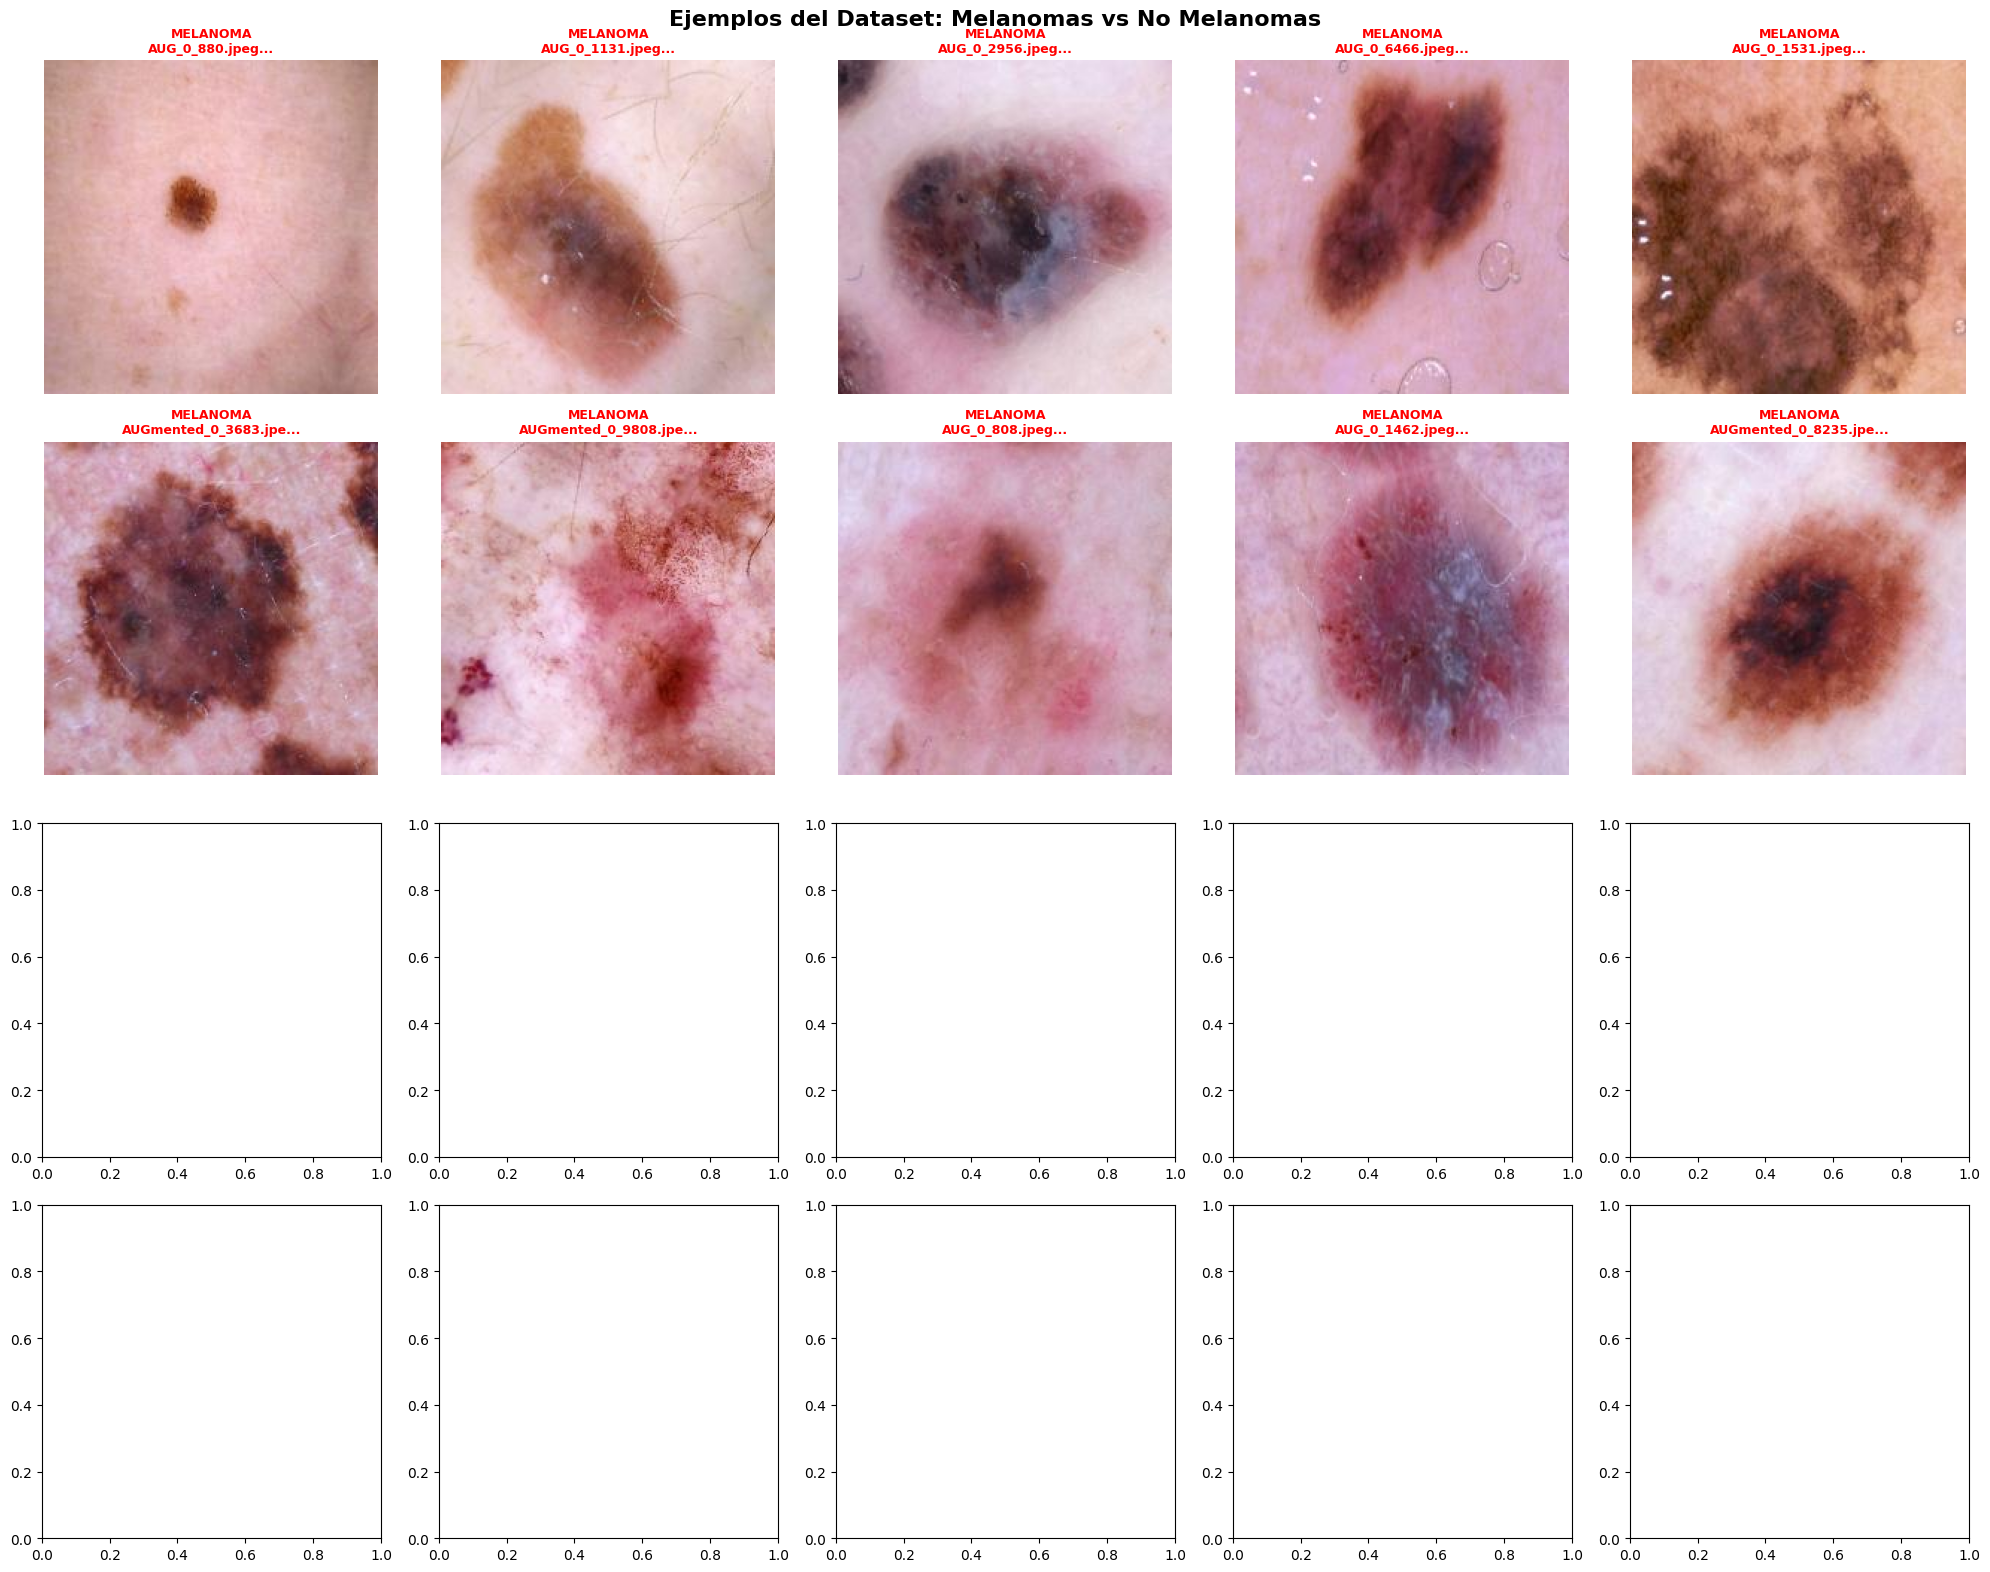


✓ Dataset balanceado: igual número de melanomas y no melanomas


In [229]:
# Visualizar ejemplos de ambas clases
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle('Ejemplos del Dataset: Melanomas vs No Melanomas', fontsize=16, fontweight='bold')

# Obtener rutas de imágenes de train
melanoma_imgs = glob(os.path.join(dataset_path, 'train_sep/Melanoma/*.jpeg'))[:10]
not_melanoma_imgs = glob(os.path.join(dataset_path, 'train_sep/NotMelanoma/*.jpeg'))[:10]

# Mostrar melanomas (primeras 2 filas)
for idx, img_path in enumerate(melanoma_imgs):
    row = idx // 5
    col = idx % 5
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"MELANOMA\n{os.path.basename(img_path)[:20]}...", 
                             fontsize=9, color='red', fontweight='bold')
    axes[row, col].axis('off')

# Mostrar no melanomas (últimas 2 filas)
for idx, img_path in enumerate(not_melanoma_imgs):
    row = (idx // 5) + 2
    col = idx % 5
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"NO MELANOMA\n{os.path.basename(img_path)[:20]}...", 
                             fontsize=9, color='green', fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Dataset balanceado: igual número de melanomas y no melanomas")

## 3. Data Augmentation

Aplicaremos **data augmentation** solo al conjunto de entrenamiento para:
- Aumentar la diversidad visual sin recolectar más datos
- Reducir **overfitting** 
- Mejorar la capacidad de **generalización**

**Augmentation aplicado:**
- Rotaciones moderadas (±15°)
- Flips horizontales
- Zoom aleatorio (90%-110%)
- Desplazamiento (±10%)
- Variación de brillo (±10%)

**Nota:** Validación y Test NO usan augmentation para medir el desempeño real.

In [230]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Configuración
IMG_SIZE = 224  # EfficientNetV2-S espera 224x224
BATCH_SIZE = 32
RANDOM_STATE = 42

# Data augmentation para entrenamiento
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalización de EfficientNetV2
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.03,
    zoom_range=0.10,
    brightness_range=[0.90, 1.10],
    horizontal_flip=True,
    fill_mode='reflect'
)

# Sin augmentation para validación y test
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

print("="*60)
print("DATA AUGMENTATION CONFIGURADO")
print("="*60)
print(f"\nImagen de entrada: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Preprocesamiento: EfficientNetV2 preprocess_input")
print("="*60)

DATA AUGMENTATION CONFIGURADO

Imagen de entrada: 224x224
Batch size: 32
Preprocesamiento: EfficientNetV2 preprocess_input


## 4. Crear Generadores de Datos

Usaremos `flow_from_directory()` que carga imágenes directamente desde carpetas, ideal para nuestro dataset ya organizado.

In [231]:
# Crear generadores
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train_sep'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=RANDOM_STATE
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'valid'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("="*60)
print("GENERADORES CREADOS")
print("="*60)
print(f"\nTrain: {train_generator.samples} imágenes")
print(f"Validation: {val_generator.samples} imágenes")
print(f"Test: {test_generator.samples} imágenes")
print(f"\nClases: {train_generator.class_indices}")
print("="*60)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.
GENERADORES CREADOS

Train: 10682 imágenes
Validation: 3562 imágenes
Test: 3561 imágenes

Clases: {'Melanoma': 0, 'NotMelanoma': 1}


## 5. Entrenamiento del Modelo

### 5.1. Configuración de Hiperparámetros

In [232]:
# Hiperparámetros del modelo
DROPOUT_RATE = 0.4
DENSE_UNITS = 128

# Umbral global para clasificación binaria (melanoma vs no melanoma)
THRESHOLD = 0.22  # Modificar este valor para probar diferentes umbrales

# Etapa 1 (solo cabeza)
LR_STAGE1 = 0.001
EPOCHS_STAGE1 = 10
PATIENCE_STAGE1 = 5

# Etapa 2 (fine-tuning)
LR_STAGE2 = 0.00001
EPOCHS_STAGE2 = 20
PATIENCE_STAGE2 = 7
UNFREEZE_FROM = 100

print("Hiperparámetros configurados")
print(f"Umbral global de clasificación (THRESHOLD): {THRESHOLD}")

Hiperparámetros configurados
Umbral global de clasificación (THRESHOLD): 0.22


### 5.2. Construcción del Modelo

In [233]:
import os
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Verificar si el modelo final ya existe (persistencia de Kaggle)
MODEL_PATH = '/kaggle/working/final_melanoma_model.keras'

if os.path.exists(MODEL_PATH):
    print("="*60)
    print("MODELO YA ENTRENADO ENCONTRADO")
    print("="*60)
    print(f"Cargando modelo desde: {MODEL_PATH}")
    model = load_model(MODEL_PATH)
    print("✓ Modelo cargado exitosamente desde /kaggle/working/")
    print("="*60)
    print("\nSALTANDO SECCIONES DE ENTRENAMIENTO (5.3, 5.4)")
    print("Si quieres re-entrenar, elimina el archivo o cambia MODEL_PATH")
    print("="*60)
    
    # Flag para saltar el entrenamiento
    SKIP_TRAINING = True
    
else:
    print("="*60)
    print("NO SE ENCONTRÓ MODELO - INICIANDO ENTRENAMIENTO")
    print("="*60)
    
    # Cargar EfficientNetV2-S sin la capa de clasificación
    base_model = EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Congelar el backbone inicialmente
    base_model.trainable = False

    # Construir la cabeza de clasificación
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(DENSE_UNITS, activation='relu')(x)
    x = Dropout(DROPOUT_RATE)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Crear el modelo completo
    model = Model(inputs=base_model.input, outputs=output)

    # Contar parámetros
    trainable_params = sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = sum([np.prod(v.shape) for v in model.non_trainable_weights])

    print("MODELO CREADO")
    print("="*60)
    print(f"Backbone: EfficientNetV2-S (ImageNet)")
    print(f"Parámetros entrenables: {trainable_params:,}")
    print(f"Parámetros congelados: {non_trainable_params:,}")
    print("="*60)
    
    # Flag para ejecutar el entrenamiento
    SKIP_TRAINING = False

MODELO YA ENTRENADO ENCONTRADO
Cargando modelo desde: /kaggle/working/final_melanoma_model.keras
✓ Modelo cargado exitosamente desde /kaggle/working/

SALTANDO SECCIONES DE ENTRENAMIENTO (5.3, 5.4)
Si quieres re-entrenar, elimina el archivo o cambia MODEL_PATH


### 5.3. Etapa 1: Entrenar Solo la Cabeza

In [234]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall

if not SKIP_TRAINING:
    # Compilar el modelo
    model.compile(
        optimizer=Adam(learning_rate=LR_STAGE1),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )

    # Callbacks
    checkpoint_stage1 = ModelCheckpoint(
        '/kaggle/working/best_model_stage1.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    early_stopping_stage1 = EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=PATIENCE_STAGE1,
        restore_best_weights=True,
        verbose=1
    )

    print("Modelo compilado para Etapa 1")
else:
    print("Saltando compilación - Modelo ya entrenado")

Saltando compilación - Modelo ya entrenado


In [235]:
if not SKIP_TRAINING:
    # Entrenar Etapa 1
    print("="*60)
    print("ENTRENANDO ETAPA 1 - SOLO CABEZA")
    print("="*60)

    history_stage1 = model.fit(
        train_generator,
        epochs=EPOCHS_STAGE1,
        validation_data=val_generator,
        callbacks=[checkpoint_stage1, early_stopping_stage1],
        verbose=1
    )

    print("\nEtapa 1 completada")
else:
    print("Saltando Etapa 1 de entrenamiento")

Saltando Etapa 1 de entrenamiento


### 5.4. Etapa 2: Fine-Tuning

In [236]:
if not SKIP_TRAINING:
    # Descongelar el backbone
    base_model.trainable = True

    # Congelar las primeras capas
    for layer in base_model.layers[:UNFREEZE_FROM]:
        layer.trainable = False

    # Contar parámetros
    trainable_params_stage2 = sum([np.prod(v.shape) for v in model.trainable_weights])

    print("="*60)
    print("DESCONGELADO PARA FINE-TUNING")
    print("="*60)
    print(f"Capas descongeladas: {len(base_model.layers) - UNFREEZE_FROM}")
    print(f"Parámetros entrenables: {trainable_params_stage2:,}")

    print("="*60)
else:
    print("Saltando descongelamiento - Modelo ya entrenado")

Saltando descongelamiento - Modelo ya entrenado


In [237]:
if not SKIP_TRAINING:
    # Re-compilar con learning rate muy bajo
    model.compile(
        optimizer=Adam(learning_rate=LR_STAGE2),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )

    # Callbacks
    checkpoint_stage2 = ModelCheckpoint(
        '/kaggle/working/best_model_stage2.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    early_stopping_stage2 = EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=PATIENCE_STAGE2,
        restore_best_weights=True,
        verbose=1
    )

    print("Modelo recompilado para Etapa 2")
else:
    print("Saltando recompilación - Modelo ya entrenado")

Saltando recompilación - Modelo ya entrenado


In [238]:
if not SKIP_TRAINING:
    # Entrenar Etapa 2
    print("="*60)
    print("ENTRENANDO ETAPA 2 - FINE-TUNING")
    print("="*60)

    history_stage2 = model.fit(
        train_generator,
        epochs=EPOCHS_STAGE2,
        validation_data=val_generator,
        callbacks=[checkpoint_stage2, early_stopping_stage2],
        verbose=1
    )

    print("\nFine-tuning completado")
else:
    print("Saltando Etapa 2 de entrenamiento")

Saltando Etapa 2 de entrenamiento


In [239]:
if not SKIP_TRAINING:
    model.save('/kaggle/working/final_melanoma_model.keras')
    print("Modelo guardado como '/kaggle/working/final_melanoma_model.keras'")
else:
    print("Modelo ya estaba guardado - No es necesario guardar nuevamente")

Modelo ya estaba guardado - No es necesario guardar nuevamente


### 5.5. Visualización de Curvas de Entrenamiento

In [240]:
import matplotlib.pyplot as plt

if not SKIP_TRAINING:
    # Combinar historiales de ambas etapas
    def combine_histories(hist1, hist2):
        """Combina dos historiales de entrenamiento"""
        combined = {}
        for key in hist1.history.keys():
            combined[key] = hist1.history[key] + hist2.history[key]
        return combined

    combined_history = combine_histories(history_stage1, history_stage2)

    # Configurar la figura
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Curvas de Entrenamiento - Transfer Learning (2 Etapas)', 
                 fontsize=16, fontweight='bold')

    # Marcar la separación entre etapas
    epoch_split = len(history_stage1.history['loss'])
    total_epochs = len(combined_history['loss'])

    # Gráfico 1: Loss
    ax1 = axes[0, 0]
    ax1.plot(combined_history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(combined_history['val_loss'], label='Val Loss', linewidth=2)
    ax1.axvline(x=epoch_split-1, color='red', linestyle='--', linewidth=2, 
                label=f'Fin Etapa 1 (época {epoch_split})')
    ax1.set_title('Loss (Binary Crossentropy)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Gráfico 2: AUC
    ax2 = axes[0, 1]
    ax2.plot(combined_history['auc'], label='Train AUC', linewidth=2)
    ax2.plot(combined_history['val_auc'], label='Val AUC', linewidth=2)
    ax2.axvline(x=epoch_split-1, color='red', linestyle='--', linewidth=2,
                label=f'Fin Etapa 1 (época {epoch_split})')
    ax2.set_title('AUC (Area Under ROC Curve)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('AUC')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Gráfico 3: Precision
    ax3 = axes[1, 0]
    ax3.plot(combined_history['precision'], label='Train Precision', linewidth=2)
    ax3.plot(combined_history['val_precision'], label='Val Precision', linewidth=2)
    ax3.axvline(x=epoch_split-1, color='red', linestyle='--', linewidth=2,
                label=f'Fin Etapa 1 (época {epoch_split})')
    ax3.set_title('Precision', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Época')
    ax3.set_ylabel('Precision')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # Gráfico 4: Recall
    ax4 = axes[1, 1]
    ax4.plot(combined_history['recall'], label='Train Recall', linewidth=2)
    ax4.plot(combined_history['val_recall'], label='Val Recall', linewidth=2)
    ax4.axvline(x=epoch_split-1, color='red', linestyle='--', linewidth=2,
                label=f'Fin Etapa 1 (época {epoch_split})')
    ax4.set_title('Recall (Sensibilidad)', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Época')
    ax4.set_ylabel('Recall')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves_finetuning.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nGráfico guardado en: training_curves_finetuning.png")
else:
    print("Saltando visualización de curvas - Modelo cargado previamente")

Saltando visualización de curvas - Modelo cargado previamente


In [241]:
if not SKIP_TRAINING:
    # Resumen de resultados finales
    print("="*60)
    print("RESUMEN DEL ENTRENAMIENTO")
    print("="*60)

    print(f"\nETAPA 1 (Solo cabeza - {len(history_stage1.history['loss'])} épocas):")
    print(f"  Train Loss: {history_stage1.history['loss'][-1]:.4f}")
    print(f"  Val Loss:   {history_stage1.history['val_loss'][-1]:.4f}")
    print(f"  Train AUC:  {history_stage1.history['auc'][-1]:.4f}")
    print(f"  Val AUC:    {history_stage1.history['val_auc'][-1]:.4f}")

    print(f"\nETAPA 2 (Fine-tuning - {len(history_stage2.history['loss'])} épocas):")
    print(f"  Train Loss: {history_stage2.history['loss'][-1]:.4f}")
    print(f"  Val Loss:   {history_stage2.history['val_loss'][-1]:.4f}")
    print(f"  Train AUC:  {history_stage2.history['auc'][-1]:.4f}")
    print(f"  Val AUC:    {history_stage2.history['val_auc'][-1]:.4f}")

    print(f"\nMEJOR MODELO (guardado):")
    best_val_auc = max(combined_history['val_auc'])
    best_epoch = combined_history['val_auc'].index(best_val_auc) + 1
    print(f"  Mejor Val AUC: {best_val_auc:.4f} (época {best_epoch})")
    print(f"  Archivo: /kaggle/working/best_model_stage2.keras")

    print("\n" + "="*60)
    print("FINE-TUNING COMPLETADO EXITOSAMENTE")
    print("="*60)
    print("\nPróximos pasos:")
    print("  1. Evaluar el modelo en el conjunto de test")
    print("  2. Calcular métricas detalladas (ROC-AUC, PR-AUC, Confusion Matrix)")
    print("  3. Ajustar umbral de decisión para maximizar recall")
    print("  4. Implementar XAI (Grad-CAM) para interpretabilidad")
    print("\n" + "="*60)
else:
    print("Saltando resumen - Modelo cargado desde archivo")

Saltando resumen - Modelo cargado desde archivo


## 6. Evaluación del Modelo

### 6.1. Generar Predicciones en Test

In [242]:
from tensorflow.keras.models import load_model

# Cargar el mejor modelo
best_model = load_model('best_model_stage2.keras')
print("Mejor modelo cargado")

Mejor modelo cargado


### 6.2. Calcular predicciones y probabilidades

In [243]:
# Resetear el generador de test
test_generator.reset()

# Generar predicciones
y_pred_proba = best_model.predict(test_generator, verbose=1).flatten()

# Obtener etiquetas verdaderas
y_test = test_generator.classes

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 35s 235ms/step


### 6.3 Maximizar Fbeta para encontrar el mejor umbral

In [244]:
import numpy as np
from sklearn.metrics import fbeta_score

# ==========================
# CONFIGURACIÓN F-BETA
# ==========================
BETA = 2.0   # >1 → da más peso al recall
print(f"Usando F-beta con beta = {BETA}")

# ==========================
# BARRIDO DE THRESHOLDS
# ==========================
# por ejemplo 1001 thresholds entre 0 y 1
thresholds = np.linspace(0.0, 1.0, 1001)

best_fbeta = -1
best_threshold = 0.5

for t in thresholds:
    y_pred_tmp = (y_pred_proba >= t).astype(int)
    score = fbeta_score(y_test, y_pred_tmp, beta=BETA, zero_division=0)
    if score > best_fbeta:
        best_fbeta = score
        best_threshold = t

print(f"\nMejor threshold según F-beta (beta={BETA}): {best_threshold:.4f}")
print(f"F-beta máximo: {best_fbeta:.4f}")

# Actualizamos el THRESHOLD global
THRESHOLD = float(best_threshold)
print(f"\nTHRESHOLD global actualizado a: {THRESHOLD:.4f}")


Usando F-beta con beta = 2.0

Mejor threshold según F-beta (beta=2.0): 0.0210
F-beta máximo: 0.9769

THRESHOLD global actualizado a: 0.0210


### 6.4 Generar predicciones binarias usando el umbral escogido

In [245]:
# Predicciones binarias usando el umbral global
y_pred = (y_pred_proba >= THRESHOLD).astype(int)

print(f"\nPredicciones generadas: {len(y_pred)}")
print(f"Umbral utilizado (THRESHOLD): {THRESHOLD}")


Predicciones generadas: 3561
Umbral utilizado (THRESHOLD): 0.021


### 6.3. Métricas de Evaluación

In [246]:
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    confusion_matrix, 
    classification_report,
    roc_curve,
    precision_recall_curve
)

# Calcular ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calcular PR-AUC (Precision-Recall AUC)
pr_auc = average_precision_score(y_test, y_pred_proba)

# Matriz de confusión con umbral actual (THRESHOLD)
cm_default = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm_default.ravel()

# Métricas derivadas
sensitivity_default = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
specificity_default = tn / (tn + fp) if (tn + fp) > 0 else 0
precision_default = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_default = 2 * (precision_default * sensitivity_default) / (precision_default + sensitivity_default) if (precision_default + sensitivity_default) > 0 else 0

print("="*60)
print("MÉTRICAS DE EVALUACIÓN - TEST SET")
print("="*60)

print(f"\nMÉTRICAS GENERALES:")
print(f"  ROC-AUC:     {roc_auc:.4f}")
print(f"  PR-AUC:      {pr_auc:.4f}")

print(f"\nMÉTRICAS CON UMBRAL THRESHOLD = {THRESHOLD}:")
print(f"  Sensibilidad (Recall):  {sensitivity_default:.4f} ({100*sensitivity_default:.1f}%)")
print(f"  Especificidad:          {specificity_default:.4f} ({100*specificity_default:.1f}%)")
print(f"  Precisión:              {precision_default:.4f} ({100*precision_default:.1f}%)")
print(f"  F1-Score:               {f1_default:.4f}")

print(f"\nMATRIZ DE CONFUSIÓN (umbral THRESHOLD = {THRESHOLD}):")
print(f"  ┌─────────────────────────┐")
print(f"  │  TN={tn:<6}  FP={fp:<6}   │")
print(f"  │  FN={fn:<6}  TP={tp:<6}   │")
print(f"  └─────────────────────────┘")
print(f"\n  Verdaderos Negativos (TN): {tn}")
print(f"  Falsos Positivos (FP):     {fp}")
print(f"  Falsos Negativos (FN):     {fn}  [Crítico en contexto clínico]")
print(f"  Verdaderos Positivos (TP): {tp}")

print("\n" + "="*60)

MÉTRICAS DE EVALUACIÓN - TEST SET

MÉTRICAS GENERALES:
  ROC-AUC:     0.9880
  PR-AUC:      0.9859

MÉTRICAS CON UMBRAL THRESHOLD = 0.021:
  Sensibilidad (Recall):  0.9989 (99.9%)
  Especificidad:          0.8866 (88.7%)
  Precisión:              0.8980 (89.8%)
  F1-Score:               0.9457

MATRIZ DE CONFUSIÓN (umbral THRESHOLD = 0.021):
  ┌─────────────────────────┐
  │  TN=1579    FP=202      │
  │  FN=2       TP=1778     │
  └─────────────────────────┘

  Verdaderos Negativos (TN): 1579
  Falsos Positivos (FP):     202
  Falsos Negativos (FN):     2  [Crítico en contexto clínico]
  Verdaderos Positivos (TP): 1778



### 6.4. Curva ROC

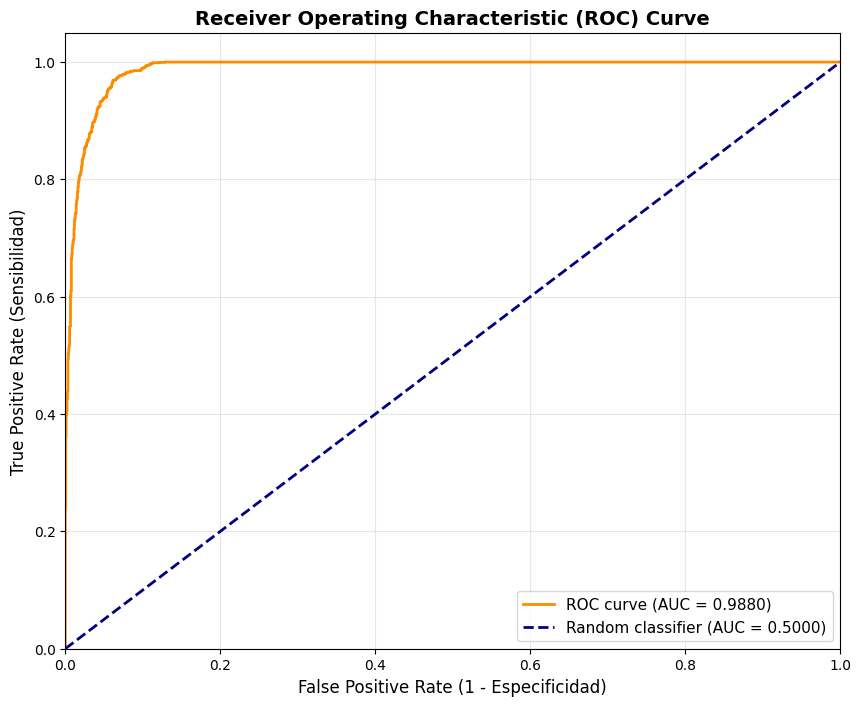

Curva ROC guardada en: roc_curve.png


In [247]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)

# Crear figura
plt.figure(figsize=(10, 8))

# Plotear curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')

# Línea de clasificador aleatorio
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random classifier (AUC = 0.5000)')

# Configuración
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Especificidad)', fontsize=12)
plt.ylabel('True Positive Rate (Sensibilidad)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)

# Guardar y mostrar
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("Curva ROC guardada en: roc_curve.png")

### 6.5. Curva Precision-Recall

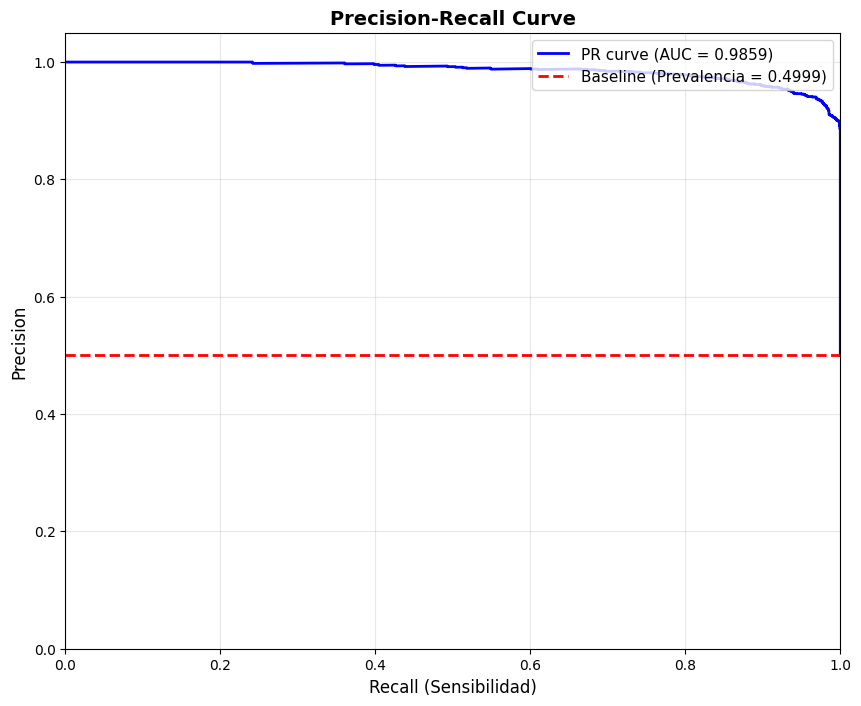

Curva Precision-Recall guardada en: precision_recall_curve.png


In [248]:
# Calcular curva Precision-Recall
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

# Calcular baseline (proporción de positivos)
baseline = y_test.sum() / len(y_test)

# Crear figura
plt.figure(figsize=(10, 8))

# Plotear curva PR
plt.plot(recall_curve, precision_curve, color='blue', lw=2,
         label=f'PR curve (AUC = {pr_auc:.4f})')

# Línea baseline
plt.axhline(y=baseline, color='red', linestyle='--', lw=2,
            label=f'Baseline (Prevalencia = {baseline:.4f})')

# Configuración
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensibilidad)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="upper right", fontsize=11)
plt.grid(alpha=0.3)

# Guardar y mostrar
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("Curva Precision-Recall guardada en: precision_recall_curve.png")

### 6.6. Matriz de Confusión

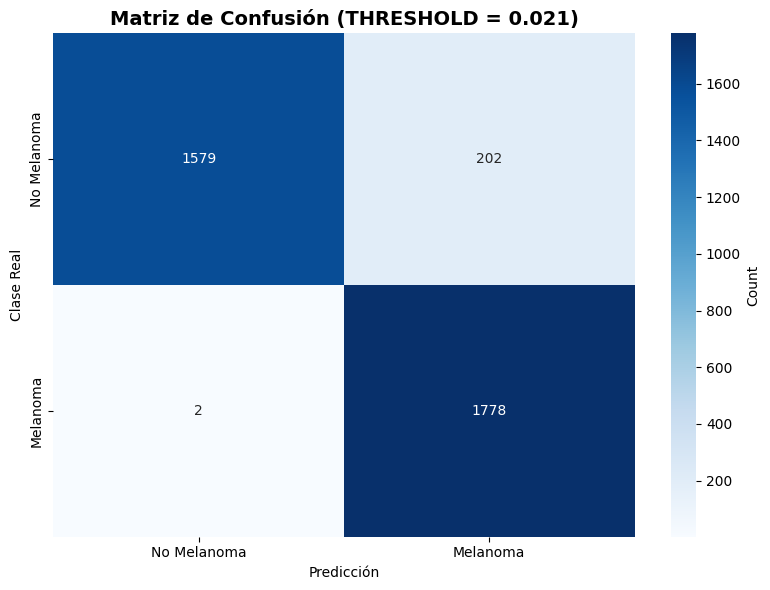


TN=1579, FP=202, FN=2, TP=1778
Umbral utilizado (THRESHOLD): 0.021


In [249]:
# Simplificado - solo mostrar la matriz de confusión con el umbral global
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Melanoma', 'Melanoma'],
            yticklabels=['No Melanoma', 'Melanoma'],
            cbar_kws={'label': 'Count'})
plt.title(f'Matriz de Confusión (THRESHOLD = {THRESHOLD})', fontsize=14, fontweight='bold')
plt.ylabel('Clase Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nTN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Umbral utilizado (THRESHOLD): {THRESHOLD}")

## 7. Explainable AI (XAI) - Grad-CAM

Implementaremos Grad-CAM para visualizar qué regiones de la imagen influyen en las predicciones del modelo.

In [250]:
# Instalar tf-keras-vis para Grad-CAM
!pip install -q tf-keras-vis

print("✓ tf-keras-vis instalado correctamente")

✓ tf-keras-vis instalado correctamente


### 7.1. Funciones de Grad-CAM

In [251]:
import tf_keras_vis
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow.keras.models import Model
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from scipy.ndimage import zoom

def overlay_gradcam(img, heatmap, alpha=0.4):
    """
    Superpone un heatmap Grad-CAM sobre una imagen (sin cv2).
    
    Args:
        img: Imagen original (H, W, 3) en rango [0, 255]
        heatmap: Mapa de calor normalizado
        alpha: Intensidad de superposición
    
    Returns:
        Imagen con heatmap superpuesto
    """
    # Normalizar heatmap entre 0 y 1
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()
    
    # Redimensionar heatmap al tamaño de la imagen usando zoom de scipy
    zoom_factor = (img.shape[0] / heatmap.shape[0], img.shape[1] / heatmap.shape[1])
    heatmap_resized = zoom(heatmap, zoom_factor, order=1)
    
    # Aplicar colormap jet de matplotlib
    colormap = cm.get_cmap('jet')
    heatmap_colored = colormap(heatmap_resized)[:, :, :3]  # RGB sin canal alpha
    heatmap_colored = (heatmap_colored * 255).astype(np.uint8)
    
    # Superponer
    img = img.astype(np.uint8)
    superimposed_img = heatmap_colored * alpha + img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    return superimposed_img


print("="*60)
print("TF-KERAS-VIS GRAD-CAM CONFIGURADO")
print("="*60)
print("\nLibrería: tf-keras-vis (sin OpenCV)")
print("Método: Gradcam con BinaryScore")
print("Visualización: matplotlib colormap + scipy zoom")
print("="*60)

TF-KERAS-VIS GRAD-CAM CONFIGURADO

Librería: tf-keras-vis (sin OpenCV)
Método: Gradcam con BinaryScore
Visualización: matplotlib colormap + scipy zoom


### 7.2. Identificar Última Capa Convolucional

In [252]:
# Crear instancia de Gradcam con tf-keras-vis
# No necesitamos especificar la capa, tf-keras-vis la encuentra automáticamente

# Modificador para reemplazar la activación final con linear (requerido para Grad-CAM)
replace2linear = ReplaceToLinear()

# Crear el objeto Gradcam
gradcam = Gradcam(best_model, model_modifier=replace2linear, clone=True)

print("="*60)
print("GRADCAM INICIALIZADO")
print("="*60)
print("\nConfiguración:")
print("  - Biblioteca: tf-keras-vis")
print("  - Modelo: EfficientNetV2-S")
print("  - Score function: BinaryScore (clasificación binaria)")
print("  - Model modifier: ReplaceToLinear")
print("\nGrad-CAM encontrará automáticamente la mejor capa convolucional")
print("="*60)

GRADCAM INICIALIZADO

Configuración:
  - Biblioteca: tf-keras-vis
  - Modelo: EfficientNetV2-S
  - Score function: BinaryScore (clasificación binaria)
  - Model modifier: ReplaceToLinear

Grad-CAM encontrará automáticamente la mejor capa convolucional


### 7.3. Visualizar Grad-CAM

GENERANDO VISUALIZACIONES GRAD-CAM CON TF-KERAS-VIS

Casos encontrados (THRESHOLD = 0.021):
  Verdaderos Positivos (TP): 1778

Procesando Verdaderos Positivos (TP)...


/tmp/ipykernel_47/1653655983.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet')


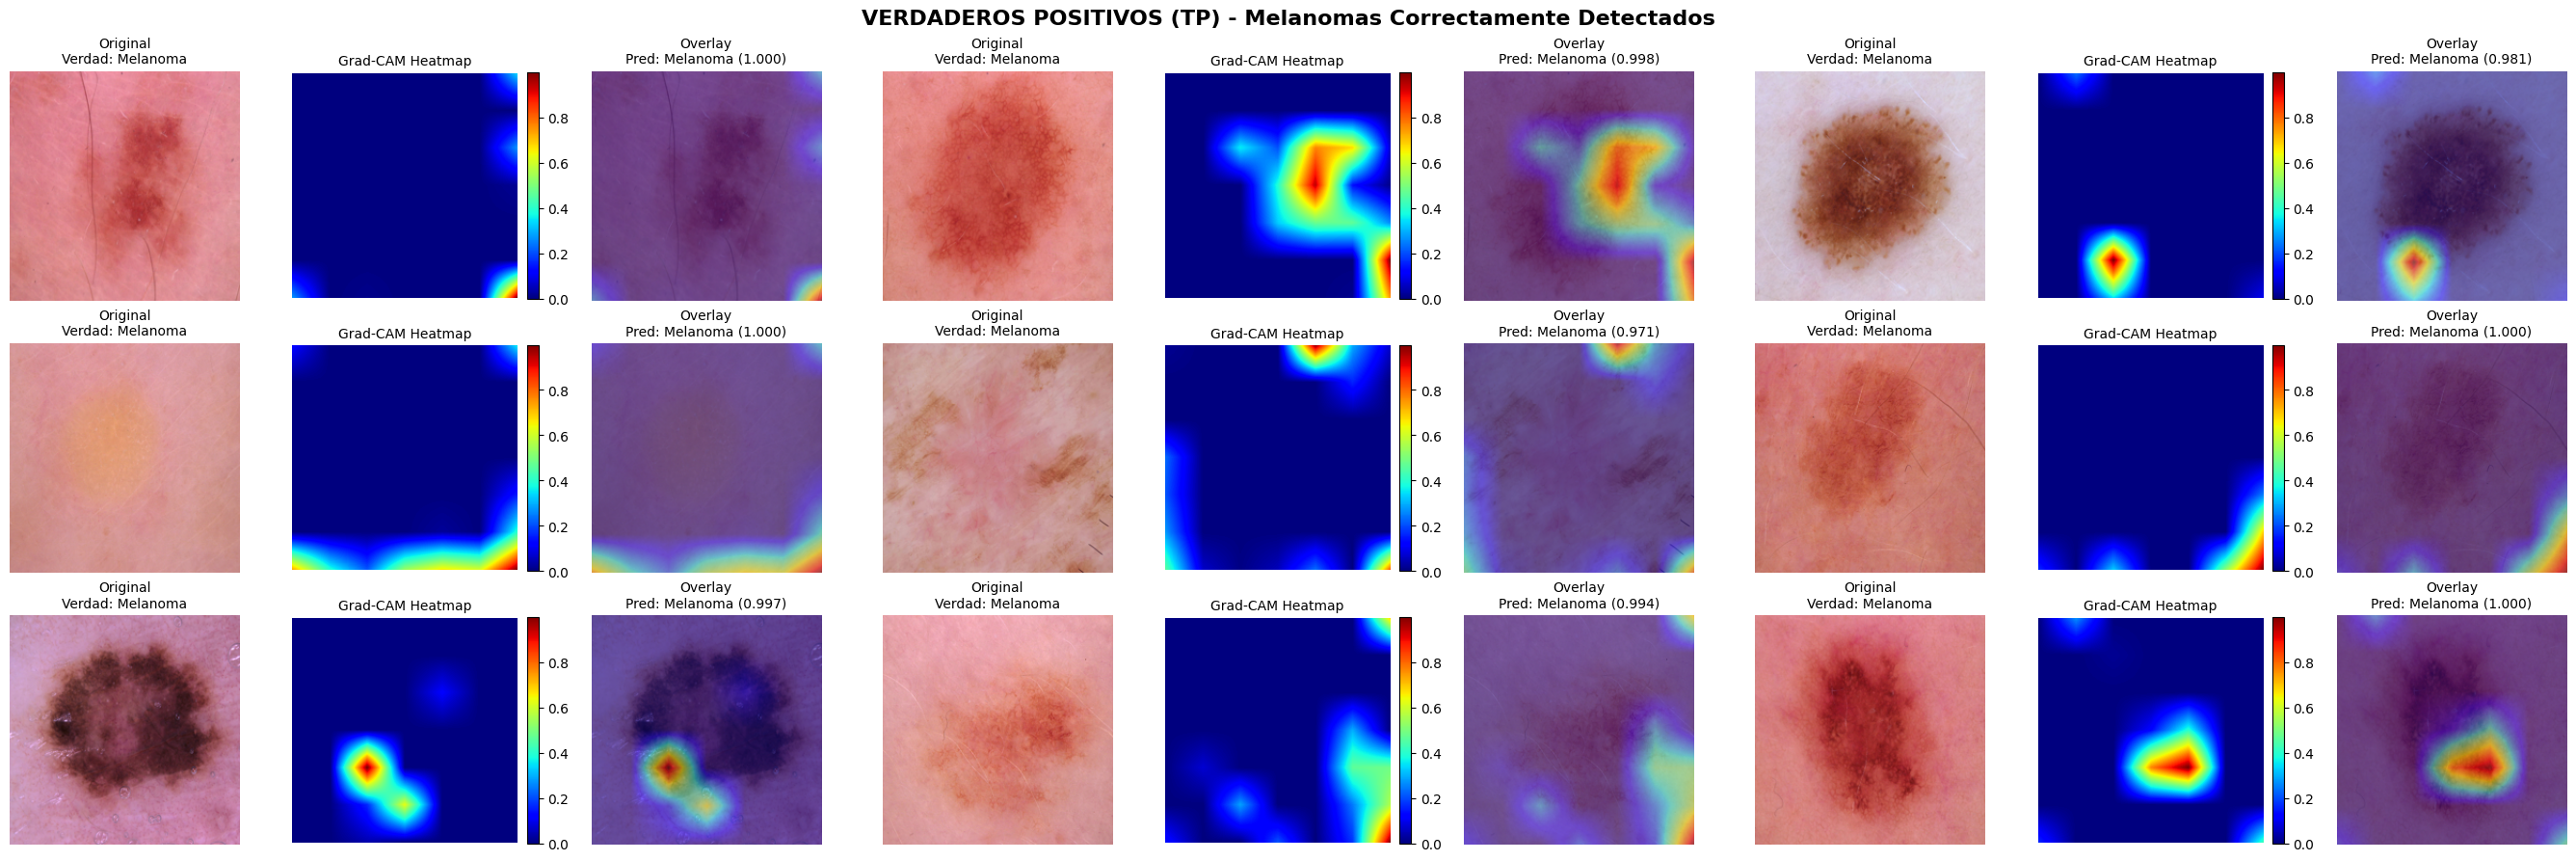

Guardado: gradcam_true_positives.png


In [253]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

def visualize_gradcam_cases(cases, X_data, y_true, y_pred_proba, title, 
                           gradcam_obj, n_cols=3):
    """
    Visualiza casos con Grad-CAM usando tf-keras-vis.
    
    Args:
        cases: Índices de los casos a visualizar
        X_data: Imágenes originales
        y_true: Etiquetas verdaderas
        y_pred_proba: Probabilidades predichas
        title: Título de la figura
        gradcam_obj: Objeto Gradcam de tf-keras-vis
        n_cols: Número de columnas en la cuadrícula
    """
    if len(cases) == 0:
        print(f"No hay casos disponibles para {title}")
        return
    
    n_cases = min(len(cases), 9)  # Limitar a 9 casos máximo
    cases = cases[:n_cases]
    n_rows = (n_cases + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols * 3, figsize=(n_cols * 9, n_rows * 3))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    
    # Preparar todas las imágenes para procesamiento en batch
    images_batch = []
    for case_idx in cases:
        img = X_data[case_idx]
        images_batch.append(img)
    
    images_batch = np.array(images_batch)
    
    # Preprocesar para el modelo
    images_preprocessed = preprocess_input(images_batch.astype(np.float32))
    
    # Generar todos los heatmaps de una vez usando tf-keras-vis
    # BinaryScore para clasificación binaria (score=1 para clase positiva)
    score = BinaryScore(0)  # 0 es el índice para la salida del modelo binario
    heatmaps = gradcam_obj(score, images_preprocessed, penultimate_layer=-1)
    
    # Visualizar cada caso
    for idx, case_idx in enumerate(cases):
        row = idx // n_cols
        col_base = (idx % n_cols) * 3
        
        # Imagen original
        img_original = X_data[case_idx]
        heatmap = heatmaps[idx]
        
        # Overlay Grad-CAM
        gradcam_img = overlay_gradcam(img_original, heatmap, alpha=0.5)
        
        # Información de la predicción
        true_label = "Melanoma" if y_true[case_idx] == 1 else "No Melanoma"
        pred_prob = y_pred_proba[case_idx]
        pred_label = "Melanoma" if pred_prob >= THRESHOLD else "No Melanoma"
        
        # Plotear imagen original
        ax_orig = axes[row, col_base]
        ax_orig.imshow(img_original.astype(np.uint8))
        ax_orig.set_title(f"Original\nVerdad: {true_label}", fontsize=10)
        ax_orig.axis('off')
        
        # Plotear heatmap puro
        ax_heat = axes[row, col_base + 1]
        im = ax_heat.imshow(heatmap, cmap='jet')
        ax_heat.set_title(f"Grad-CAM Heatmap", fontsize=10)
        ax_heat.axis('off')
        plt.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
        
        # Plotear overlay
        ax_overlay = axes[row, col_base + 2]
        ax_overlay.imshow(gradcam_img)
        ax_overlay.set_title(f"Overlay\nPred: {pred_label} ({pred_prob:.3f})", fontsize=10)
        ax_overlay.axis('off')
    
    # Ocultar ejes no utilizados
    for idx in range(n_cases, n_rows * n_cols):
        row = idx // n_cols
        col_base = (idx % n_cols) * 3
        for offset in range(3):
            axes[row, col_base + offset].axis('off')
    
    plt.tight_layout()
    return fig


# Preparar datos de test para visualización
# Cargar imágenes originales (sin preprocesamiento)
test_images = []
for i in range(len(test_generator.filenames)):
    img_path = os.path.join(test_generator.directory, test_generator.filenames[i])
    img = Image.open(img_path)
    img = img.resize((IMG_SIZE, IMG_SIZE))
    test_images.append(np.array(img))

X_test = np.array(test_images)

# Identificar casos de interés usando el umbral global
y_pred_binary = (y_pred_proba >= THRESHOLD).astype(int)

# Verdaderos Positivos (TP): Melanomas correctamente detectados
tp_cases = np.where((y_test == 1) & (y_pred_binary == 1))[0]

print("="*60)
print("GENERANDO VISUALIZACIONES GRAD-CAM CON TF-KERAS-VIS")
print("="*60)
print(f"\nCasos encontrados (THRESHOLD = {THRESHOLD}):")
print(f"  Verdaderos Positivos (TP): {len(tp_cases)}")
print(f"\nProcesando Verdaderos Positivos (TP)...")

fig_tp = visualize_gradcam_cases(
    tp_cases, X_test, y_test, y_pred_proba,
    "VERDADEROS POSITIVOS (TP) - Melanomas Correctamente Detectados",
    gradcam, n_cols=3
)

if fig_tp:
    plt.savefig('gradcam_true_positives.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Guardado: gradcam_true_positives.png")

### 4.4 Verdaderos Negativos (TN) - No Melanomas Correctamente Clasificados


Procesando Falsos Positivos (FP): 202 casos...


/tmp/ipykernel_47/1653655983.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet')


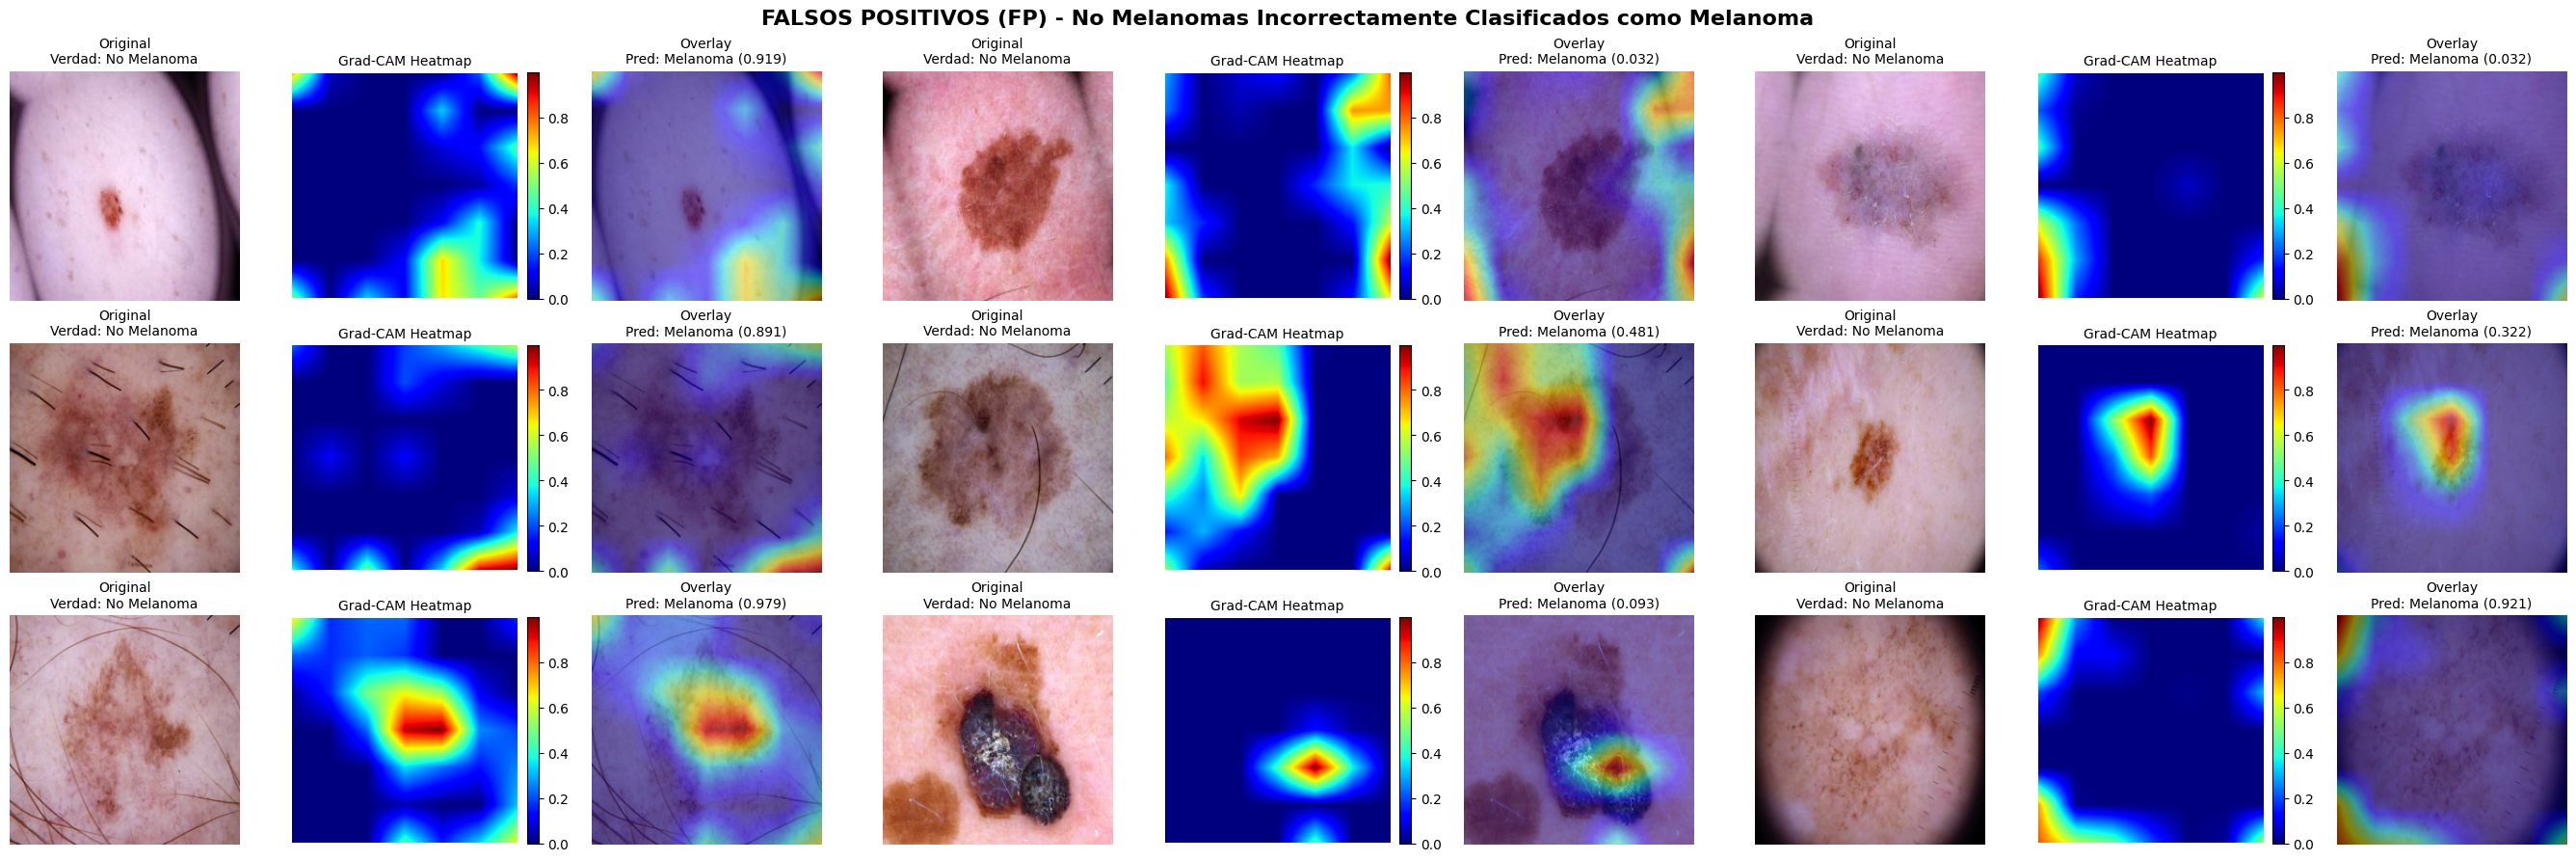

Guardado: gradcam_false_positives.png

Procesando Falsos Negativos (FN): 2 casos...


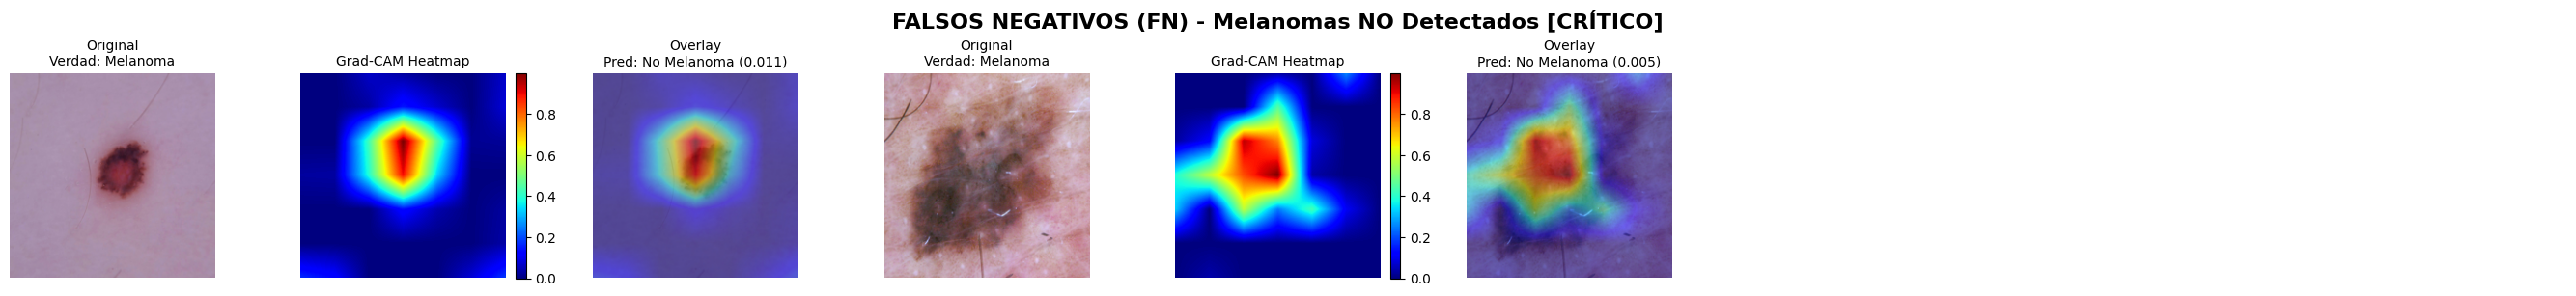

Guardado: gradcam_false_negatives.png


In [254]:
# Visualizar Falsos Positivos (FP) - opcional
fp_cases = np.where((y_test == 0) & (y_pred_binary == 1))[0]

if len(fp_cases) > 0:
    print(f"\nProcesando Falsos Positivos (FP): {len(fp_cases)} casos...")
    fig_fp = visualize_gradcam_cases(
        fp_cases, X_test, y_test, y_pred_proba,
        "FALSOS POSITIVOS (FP) - No Melanomas Incorrectamente Clasificados como Melanoma",
        gradcam, n_cols=3
    )
    if fig_fp:
        plt.savefig('gradcam_false_positives.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Guardado: gradcam_false_positives.png")
else:
    print("No hay Falsos Positivos para visualizar")

# Visualizar Falsos Negativos (FN) - Críticos en contexto médico
fn_cases = np.where((y_test == 1) & (y_pred_binary == 0))[0]

if len(fn_cases) > 0:
    print(f"\nProcesando Falsos Negativos (FN): {len(fn_cases)} casos...")
    fig_fn = visualize_gradcam_cases(
        fn_cases, X_test, y_test, y_pred_proba,
        "FALSOS NEGATIVOS (FN) - Melanomas NO Detectados [CRÍTICO]",
        gradcam, n_cols=3
    )
    if fig_fn:
        plt.savefig('gradcam_false_negatives.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Guardado: gradcam_false_negatives.png")
else:
    print("¡Excelente! No hay Falsos Negativos")

### 7.5. Análisis de Resultados Grad-CAM

Los mapas de calor generados con **tf-keras-vis** muestran qué regiones de la imagen influyen en la predicción:

**Interpretación de colores:**
- **Regiones rojas/amarillas**: Alta influencia (el modelo se enfoca aquí)
- **Regiones azules/frías**: Baja influencia

**Para un modelo médicamente confiable, esperamos que se enfoque en:**
- Bordes irregulares de la lesión
- Variación de color dentro de la lesión
- Áreas de pigmentación anómala
- Cambios de textura
- Asimetría de la lesión

**Ventajas de tf-keras-vis:**
- Implementación optimizada y probada
- Soporte para múltiples técnicas de visualización
- Manejo automático de capas convolucionales
- Mejor rendimiento en batch processing